# Laboratory Exercise 4

In this assignment, you will use the `movies.csv` dataset to build a neural network that predicts the genre of a movie from its features. After completing the classification task, you will apply clustering techniques to the dataset without the genre column to analyze how movies are grouped based on similarity and to compare these clusters with the original genre labels.

**Notes:**

- Some parts of the code are already provided. **Do not modify the existing code.**
- Write your solution only in the sections marked with `### YOUR SOLUTION`.
- You can verify automatically graded tasks using the cell labeled `### TEST` after each function.

***IMPORTANT NOTE:***
- Name your Jupyter Notebook as `lab_ex_4_{index}.ipynb`.
- For example, if your index is 123456, you should name your notebook as `lab_ex_2_12346.ipynb`.

In [49]:
import pandas as pd 
import hashlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import (
    adjusted_rand_score,
    adjusted_mutual_info_score,
    homogeneity_score,
    completeness_score,
    v_measure_score
)
import numpy as np

In [50]:
def hash_data_frame(df):
    df_sorted = df.sort_index(axis=1).sort_values(by=list(df.columns))
    return hashlib.sha256(pd.util.hash_pandas_object(df_sorted, index=True).values).hexdigest()

In [51]:
def hash_series(series):
    series_str = ",".join(map(str, series.values))
    return hashlib.sha256(series_str.encode()).hexdigest()

In [52]:
def hash_vocab(vocab):
    items = sorted(vocab.items(), key=lambda x: x[1])  
    vocab_str = "\n".join(f"{k}:{v}" for k, v in items)
    return hashlib.sha256(vocab_str.encode("utf-8")).hexdigest()

In [53]:
def hash_sequences(sequences):
    flat = []
    for seq in sequences:
        flat.extend(seq)
        flat.append(-1)  # separator to preserve sequence boundaries
    return hashlib.sha256(str(flat).encode("utf-8")).hexdigest()

In [54]:
def hash_tensor(tensor):
    return hashlib.sha256(tensor.cpu().numpy().tobytes()).hexdigest()

In [55]:
def hash_number(x):
    return hashlib.sha256(str(x).encode("utf-8")).hexdigest()

In [56]:
df = pd.read_csv("movies.csv")
df.sample()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
26382,2006,Jaan-E-Mann,Bollywood,Shirish Kunder,"Salman Khan, Akshay Kumar, Preity Zinta, Anupa...","drama, romance, musical, comedy",https://en.wikipedia.org/wiki/Jaan-E-Mann,Suhaan Kapoor (Salman Khan) and Piya Goyal (Pr...


In [57]:
### AUTOMATICALLY GRADED TASK
def filter_genres(df, genres):
    """
    Filters the dataset to include only movies belonging to the specified
    genres and ensures that the resulting DataFrame has a sequential index.

    Parameters:
    df (pandas.DataFrame): Movie dataset containing a 'Genre' column
    genres (list): Genres to retain

    Return the result as a `pd.DataFrame`.
    """

    # YOUR CODE HERE

    filtered = df[df["Genre"].isin(genres)]
    return filtered.reset_index(drop=True)
    
    # raise NotImplementedError()

In [58]:
df = filter_genres(df, ["comedy", "drama"])

In [59]:
### TEST
_df = pd.read_csv("movies.csv")
_df = filter_genres(_df, ["comedy", "drama"])
assert hash_data_frame(_df) == "edad962d401b26a758e9cfb7097272c25c68339782ddb87e9bb04558d5f72c26"

In [60]:
### MANUALLY GRADED TASK
def movie_plot_word_counts(df):
    """
    Creates a plot that shows the number of words in the movie plot descriptions.
    """
    # YOUR CODE HERE

    df["Plot"].str.split(" ").apply(len).plot.hist()
    
    # raise NotImplementedError()

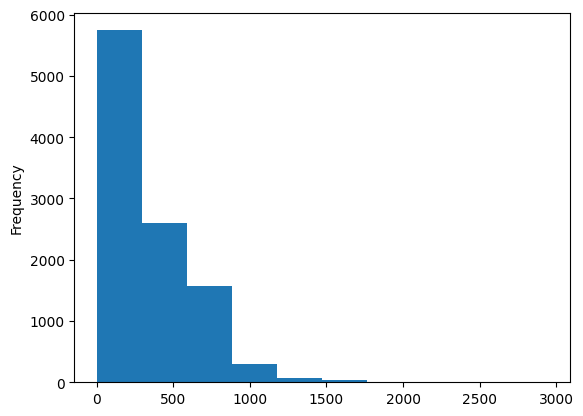

In [61]:
movie_plot_word_counts(df)

In [62]:
### AUTOMATICALLY GRADED TASK
def preprocess_plot(df):
    """
    Preprocesses the 'Plot' column by converting all text to lowercase and removing the plots 
    containing more than 1000 words and ensure that the resulting DataFrame has a sequential index. 

    Returns a pandas DataFrame.
    """

    # YOUR CODE HERE

    df["Plot"] = df["Plot"].str.lower()
    df = df[df["Plot"].str.split().apply(len) <= 1000].copy(deep=True)
    return df.reset_index(drop=True)
    
    # raise NotImplementedError()

preprocess_plot(df)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,the film is about a family who move to the sub...
1,1907,How Brown Saw the Baseball Game,American,Unknown,Unknown,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,before heading out to a baseball game at a nea...
2,1907,Laughing Gas,American,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,the plot is that of a black woman going to the...
3,1908,The Adventures of Dollie,American,D. W. Griffith,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,on a beautiful summer day a father and mother ...
4,1908,The Black Viper,American,D. W. Griffith,D. W. Griffith,drama,https://en.wikipedia.org/wiki/The_Black_Viper,a thug accosts a girl as she leaves her workpl...
...,...,...,...,...,...,...,...,...
10087,2011,Toll Booth,Turkish,Tolga Karaçelik,"Serkan Ercan, Zafer Diper & Nur Aysan",drama,https://en.wikipedia.org/wiki/Toll_Booth_(film),kenan is a 35-year-old toll booth attendant st...
10088,2011,White as Snow,Turkish,Selim Güneş,"Hakan Korkmaz, Sinem İslamoğlu & Gürkan Piri O...",drama,https://en.wikipedia.org/wiki/White_as_Snow_(f...,hasan is a twelve-year-old boy living with his...
10089,2011,Once Upon a Time in Anatolia,Turkish,Nuri Bilge Ceylan,"Yılmaz Erdoğan, Taner Birsel & Ufuk Karaali",drama,https://en.wikipedia.org/wiki/Once_Upon_a_Time...,"through the night, three cars carry a small gr..."
10090,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,"Ahmet Kural, Murat Cemcir",comedy,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"two musicians, salih and gürkan, described the..."


In [63]:
df = preprocess_plot(df)

In [64]:
### TEST
_df = pd.read_csv("movies.csv")
_df = preprocess_plot(_df)
assert hash_data_frame(_df) == "d960d3d487ec47f0b5ba182b7bc602b63db9c15a1e16076cdf78f60abc4164ef"

In [65]:
### AUTOMATICALLY GRADED TASK
def partition_dataset(df):
    """
    Split the dataset into features (X) and target (y), where the feature used is `Plot` and the target is `Genre`.
    Then, divide X and y into training, validation and test sets using an 80:20 ratio.

    If you think encoding is necessary use df[column].astype("category").cat.codes

    Use `random_state=42` to ensure reproducibility.
    
    Return the sets in the following order: train_X, val_X, test_X, train_y, val_y, test_y.
    """

    # YOUR CODE HERE
    X, y = df["Plot"], df["Genre"].astype("category").cat.codes

    train_X, test_X, train_y, test_y = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    train_X, val_X, train_y, val_y = train_test_split(
        train_X, train_y, test_size=0.2, random_state=42
    )
    
    return train_X, val_X, test_X, train_y, val_y, test_y
    
    # raise NotImplementedError()

In [66]:
train_X, val_X, test_X, train_y, val_y, test_y = partition_dataset(df)

In [67]:
## TEST
_df = pd.read_csv("movies.csv")
_train_X, _val_X, _test_X, _train_y, _val_y, _test_y = partition_dataset(_df)
assert hash_series(_train_X) == "f3f633cca3a7d238c602554f410241506f3dbb31513295c73bd76b77ff9bd34d"
assert hash_series(_val_X) == "a66099bd3b1843b84f4597741f49550d258b1b41c2a7aa692a52d32e132ceb85"
assert hash_series(_test_X) == "6ac1e882e03259be257de0c476af663e73286d3718800b0e11760485da25d332"
assert hash_series(_train_y) == "bb48348267767da5f6eba35c97ee91b0d636f20d87b7603a370f7284d06ada64"
assert hash_series(_val_y) == "146395270412839a91e034b3e6a7259f083284314818b6a02fd1a5aeb1524a1b"
assert hash_series(_test_y) == "8e0a6892cc3b60babc4e713216551a3010708a404f1f8cb2ecd47fd48c8eeaaa"

In [68]:
### AUTOMATICALLY GRADED TASK
def build_vocab(texts, max_vocab_size):
    """
    Builds a vocabulary dictionary from a list of text strings.

    The function should count word frequencies across all input texts and
    assign an integer index to each word. The vocabulary must include the
    special tokens "<PAD>" with index 0 and "<OOV>" with index 1. The remaining
    words should be added in descending order of frequency, up to the maximum
    vocabulary size.

    Parameters:
    texts (list of str): List of preprocessed text strings
    max_vocab_size (int): Maximum size of the vocabulary, including special
                          tokens

    Returns:
    dict: A dictionary mapping words to integer indices
    """

    # YOUR CODE HERE

    counter = Counter()

    for sentence in texts:
        counter.update(sentence.split())
    
    vocab = {
        "<PAD>": 0,
        "<OOV>": 1
    }

    for idx, (word, _) in enumerate(
        counter.most_common(max_vocab_size - 2), start=2
    ):
        vocab[word] = idx

    return vocab
    
    # raise NotImplementedError()

In [69]:
vocab = build_vocab(train_X.values, 100000)

In [70]:
## TEST
assert hash_vocab(vocab) == "cb5e3c6b40506bc7e0aa34474d58a04733b16b4408739ede5cb41812a0d2279e"

In [71]:
### AUTOMATICALLY GRADED TASK
def texts_to_sequences(texts, vocab):
    """
    Converts a list of text strings into sequences of integer indices using a
    given vocabulary.

    Each word in a text should be replaced by its corresponding index from the
    vocabulary. Words that are not present in the vocabulary must be mapped to
    the "<OOV>" token.

    Parameters:
    texts (list of str): List of preprocessed text strings
    vocab (dict): Vocabulary mapping words to integer indices

    Returns:
    list of list of int: List of integer sequences corresponding to the input texts
    """    

    # YOUR CODE HERE

    sequences = []

    for sentence in texts:
        seq = [
            vocab.get(word, vocab["<OOV>"])
            for word in sentence.split()
        ]
        sequences.append(seq)

    return sequences
    
    # raise NotImplementedError()

In [72]:
train_X = texts_to_sequences(train_X.values, vocab)
val_X   = texts_to_sequences(val_X.values, vocab)
test_X  = texts_to_sequences(test_X.values, vocab)

In [73]:
##TEST
assert hash_sequences(train_X) == "0402e69472cc84e0564e02f3fbf556e58b01a6cc9a5a9c864db28d968ea1d649"
assert hash_sequences(val_X) == "0b6c7bc470d2b19922835e3cc36f733a31a4389dae3cbb21572cd10327660bf7"
assert hash_sequences(test_X) == "72706aedbae3b45831ca6b62966f6736dd69f1155d65dd8b1252e4a5655a74ed"

In [74]:
### AUTOMATICALLY GRADED TASK
def pad(sequences, pad_value=0):
    """
    Pads a list of integer sequences so that all sequences have the same length.

    Shorter sequences should be padded with the specified padding value until
    they match the length of the longest sequence. The output should be a
    tensor suitable for batch processing in a neural network.

    Parameters:
    sequences (list of list of int): List of integer sequences
    pad_value (int, optional): Value used for padding (default is 0)

    Returns:
    torch.Tensor: Padded tensor of shape (batch_size, max_sequence_length)
    """
    pass

    # YOUR CODE HERE

    return pad_sequence(
        [torch.tensor(seq, dtype=torch.long) for seq in sequences],
        batch_first=True,
        padding_value=pad_value
    )
    
    # raise NotImplementedError()

In [75]:
train_X = pad(train_X, pad_value=vocab["<PAD>"])
val_X   = pad(val_X,pad_value=vocab["<PAD>"])
test_X  = pad(test_X, pad_value=vocab["<PAD>"])

In [76]:
##TEST 
assert hash_tensor(train_X) == "a512664e689288d133c84a6f8033ee516b025abf6f2305a1fbcb3fd6238e040e"
assert hash_tensor(val_X) == "933f4a3b2c14892052c211291e96b1c5d1e7691549452a485db89790158af032"
assert hash_tensor(test_X) == "f44f54df5ada534b075b1dea85f3082bae7f0584001873e21891dc58de637373"

In [77]:
class CNN_LSTM(nn.Module):
    """
    CNN–LSTM model for text classification.

    The model should consist of the following components (in order):

    1. embbedding: An embedding layer that maps token indices to 128-dimensional vectors.

    2. conv1: A 1D convolutional layer with:
       - 32 output channels
       - kernel size of 4

       This should be followed by a max-pooling layer with pool size 2.

    3. conv2: A second 1D convolutional layer with:
       - 64 output channels
       - kernel size of 4
       - appropriate padding

       This should also be followed by a max-pooling layer with pool size 2.

    4. Two LSTM layers:
       - lstm1: The first LSTM takes the convolutional features as input and has
         128 hidden units.
       - lstm2: The second LSTM takes the output of the first LSTM and has
         64 hidden units.

    5. fc: A fully connected (linear) layer.

    Hint:
    Think carefully about the activation function needed and the number of
    output neurons in the final layer. Do NOT apply an activation function in
    the model. The activation will be handled later in the optimizer.
    """

    # YOUR CODE HERE

    def __init__(self, vocab_size, num_classes):
        super().__init__()

        self.embedding = nn.Embedding(
            vocab_size, 128, padding_idx=0
        )

        self.conv1 = nn.Conv1d(128, 32, kernel_size=4, padding=2)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=4, padding=2)
        self.pool2 = nn.MaxPool1d(2)

        self.lstm1 = nn.LSTM(64, 128, batch_first=True, dropout=0.2)
        self.lstm2 = nn.LSTM(128, 64, batch_first=True, dropout=0.1)

        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x)          # (batch, seq, 128)
        x = x.permute(0, 2, 1)         # (batch, 128, seq)

        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        x = x.permute(0, 2, 1)         # (batch, seq, features)

        x, _ = self.lstm1(x)
        _, (h, _) = self.lstm2(x)

        return self.fc(h[-1])

In [78]:
### AUTOGRADED TASK
def initialize_model():
    """
    Initializes and returns a CNN-LSTM model for text classification.

    Parameters:
    vocab_size (int): Size of the vocabulary
    num_classes (int): Number of output classes

    Returns:
    torch.nn.Module: Initialized CNN-LSTM model
    """
    # YOUR CODE HERE

    device = (
        "cuda" if torch.cuda.is_available() 
        else "mps" if torch.backends.mps.is_available() 
        else "cpu"
    )
    
    model = CNN_LSTM(
        vocab_size=len(vocab),
        num_classes=1
    
    ).to(device)

    return model

In [79]:
model = initialize_model()

C:\Users\TODOROVSKI\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
C:\Users\TODOROVSKI\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


In [80]:
###TEST
assert isinstance(model, nn.Module)
assert hasattr(model, "embedding")
assert model.embedding.embedding_dim == 128
assert hasattr(model, "conv1")
assert hasattr(model, "conv2")
assert model.conv1.out_channels == 32
assert model.conv2.out_channels == 64
assert hasattr(model, "lstm1")
assert hasattr(model, "lstm2")
assert model.lstm1.hidden_size == 128
assert model.lstm2.hidden_size == 64
assert hasattr(model, "fc")
assert hash_number(model.fc.out_features) == "6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d49c01e52ddb7875b4b"

In [81]:
train_y = torch.tensor(train_y.values, dtype=torch.long)
val_y   = torch.tensor(val_y.values, dtype=torch.long)
test_y  = torch.tensor(test_y.values, dtype=torch.long)

In [82]:
### AUTOGRADED TASK
# Define the optimizer and the loss function
    # Hint:
    # Since no activation function is defined at the output layer, you should choose
    # a loss function suitable for this task that internally applies the appropriate
    # activation.
        
# YOUR CODE HERE

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [83]:
### AUTOGRADED TASK
def train_one_epoch(model, X, y, batch_size, optimizer, criterion):
    """
    Trains the model for one epoch using mini-batch gradient descent
    
    Returns:
    float: Average training loss for the epoch
    """
    # YOUR CODE HERE

    device = (
        "cuda" if torch.cuda.is_available() 
        else "mps" if torch.backends.mps.is_available() 
        else "cpu"
    )

    model.train()
    losses = 0.0

    num_batches = 0
    for i in range(0, len(X), batch_size):
        X_batch = X[i:i+batch_size].to(device)
        y_batch = y[i:i+batch_size].to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        losses += loss.item()
        num_batches += 1
        
    print(losses / num_batches)
    return losses / num_batches

In [84]:
loss = train_one_epoch(
    model,
    train_X[:64],
    train_y[:64],
    batch_size=32,
    optimizer=optimizer,
    criterion=criterion
)

0.682880699634552


In [85]:
##TEST
assert isinstance(loss, float)
assert 0.4 < loss < 0.8

In [86]:
### AUTOGRADED TASK
def evaluate(model, X, y, criterion):
    """
    Evaluates the model on a given dataset.
    Returns:
    tuple: (loss, accuracy)
    """
    # YOUR CODE HERE
    device = (
        "cuda" if torch.cuda.is_available() 
        else "mps" if torch.backends.mps.is_available() 
        else "cpu"
    )

    model.eval()
    running_val_loss = 0.0
    correct = 0

    with torch.no_grad():
        X_val = X.to(device)
        y_val = y.to(device)

        outputs = model(X_val)
        val_loss = criterion(outputs, y_val.float().unsqueeze(1))
        running_val_loss += val_loss.item()

        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).long().squeeze(1)
        correct = (preds == y_val).sum().item()

    avg_val_loss = running_val_loss
    val_acc = correct / len(y_val)
    
    print(avg_val_loss, val_acc)
    return (avg_val_loss, val_acc)

In [87]:
val_loss, val_acc = evaluate(
    model,
    train_X[:64],
    train_y[:64],
    criterion
)

0.6801166534423828 0.625


In [88]:
##TEST
assert isinstance(val_loss, float)
assert isinstance(val_acc, float)
assert 0.5 <= val_acc <= 1
assert 0.5 <= val_loss <= 1

In [89]:
def train_model(
    model, train_X, train_y, val_X, val_y,
    epochs, batch_size, optimizer, criterion
):
    """
    Trains the model for multiple epochs and evaluates it after each epoch.

    Returns:
    tuple: (train_losses, val_losses)
    """
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        train_loss = train_one_epoch(
            model, train_X, train_y, batch_size, optimizer, criterion
        )

        val_loss, val_acc = evaluate(
            model, val_X, val_y, criterion
        )

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train loss: {train_loss:.4f} | "
            f"Val loss: {val_loss:.4f} | "
            f"Val acc: {val_acc:.4f}"
        )

    return train_losses, val_losses

In [90]:
train_losses, val_losses = train_model(
    model,
    train_X[:64], train_y[:64],
    train_X[:64], train_y[:64],
    epochs=100,
    batch_size=32,
    optimizer=optimizer,
    criterion=criterion
)

0.6782242655754089
0.6759709119796753 0.625
Epoch 1/100 | Train loss: 0.6782 | Val loss: 0.6760 | Val acc: 0.6250
0.6740595102310181
0.6721002459526062 0.625
Epoch 2/100 | Train loss: 0.6741 | Val loss: 0.6721 | Val acc: 0.6250
0.670161098241806
0.6685063242912292 0.625
Epoch 3/100 | Train loss: 0.6702 | Val loss: 0.6685 | Val acc: 0.6250
0.6665579080581665
0.665338397026062 0.625
Epoch 4/100 | Train loss: 0.6666 | Val loss: 0.6653 | Val acc: 0.6250
0.6634804606437683
0.6629360914230347 0.625
Epoch 5/100 | Train loss: 0.6635 | Val loss: 0.6629 | Val acc: 0.6250
0.6613791882991791
0.6617040038108826 0.625
Epoch 6/100 | Train loss: 0.6614 | Val loss: 0.6617 | Val acc: 0.6250
0.660699188709259
0.6616367101669312 0.625
Epoch 7/100 | Train loss: 0.6607 | Val loss: 0.6616 | Val acc: 0.6250
0.661279559135437
0.6620411276817322 0.625
Epoch 8/100 | Train loss: 0.6613 | Val loss: 0.6620 | Val acc: 0.6250
0.6622146964073181
0.6622318625450134 0.625
Epoch 9/100 | Train loss: 0.6622 | Val loss: 0.6

In [91]:
### MANUALLY GRADED TASK
def plot_losses(train_losses, val_losses):
    """
    Plots training and validation loss over epochs.

    The plot should clearly show both curves and include axis labels
    and a legend.
    """
    # YOUR CODE HERE

    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

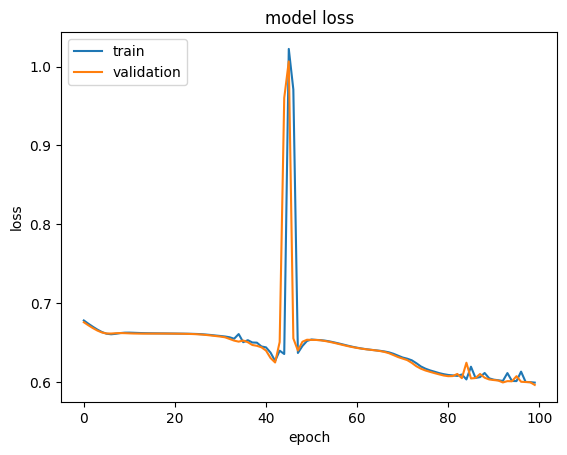

In [92]:
plot_losses(train_losses, val_losses)

In [93]:
### AUTOGRADED TASK
def evaluate_test(model, test_X, test_y):
    """
    Evaluates the trained model on the test set.

    The function should compute and return the final classification accuracy.

    Returns:
    float: Test accuracy
    """
    # YOUR CODE HERE
    device = (
        "cuda" if torch.cuda.is_available() 
        else "mps" if torch.backends.mps.is_available() 
        else "cpu"
    )

    model.eval()
    with torch.no_grad():
        X_test = test_X.to(device)
        y_test = test_y.to(device)
    
        outputs = model(X_test)
        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).long().squeeze(1)
        test_acc = (preds == y_test).sum().item() / len(y_test)
    
    print(f"Test accuracy: {test_acc:.4f}")

    return test_acc

In [94]:
test_acc = evaluate_test(model, test_X, test_y)

Test accuracy: 0.5919


In [95]:
##TEST
assert isinstance(test_acc, float)
assert 0.5 <= test_acc <= 1.0

In [96]:
### AUTOGRADED TASK
def cluster_movies(texts, true_labels):
    """
    Performs unsupervised clustering on movie plot texts.

    Requirements:
    1. Convert the input texts into numerical features using TfidfVectorizer with max_features 20000, ommiting the english stopwords
    and using ngram_range=(1, 2).
    2. Apply dimensionality reduction to make clustering more effective.
           Hint: use TruncatedSVD (a PCA-like method suitable for sparse text data).
           The number of components should be 200 and the random state 42. 
    3. Cluster the reduced representations using KMeans with 2 clusters and random state 42.
    4. Evaluate the clustering using the following external metrics:
       - Adjusted Rand Index (ARI)
       - Adjusted Mutual Information (AMI)
       - Homogeneity
       - Completeness
       - V-measure

    Important:
    - The true labels must NOT be used during clustering.
    - They are used only for evaluation.

    Parameters:
    texts (list of str): Movie plot descriptions
    true_labels (array-like): Ground truth genre labels
    n_clusters (int): Number of clusters
    random_state (int): Random seed for reproducibility

    Returns:
    dict: Dictionary containing all evaluation metrics
    """

    # YOUR CODE HERE

    # 1
    vectorizer = TfidfVectorizer(max_features=20000, stop_words="english", ngram_range=(1, 2))
    X_transformed = vectorizer.fit_transform(texts)

    # 2
    svd = TruncatedSVD(n_components=200, random_state=42)
    X_pca = svd.fit_transform(X_transformed)

    # 3
    kmeans_re = KMeans(n_clusters=2, random_state=42)
    re_clusters = kmeans_re.fit_predict(X_pca)

    # 4
    metrics = {
        "ARI": adjusted_rand_score(true_labels, re_clusters),
        "AMI": adjusted_mutual_info_score(true_labels, re_clusters),
        "Homogeneity": homogeneity_score(true_labels, re_clusters),
        "Completeness": completeness_score(true_labels, re_clusters),
        "V-measure": v_measure_score(true_labels, re_clusters),
    }

    return metrics

In [97]:
metrics = cluster_movies(
    texts=df["Plot"].values,
    true_labels=df["Genre"].astype("category").cat.codes,
)

In [98]:
metrics

{'ARI': 0.01570234866930727,
 'AMI': 0.03253757195542946,
 'Homogeneity': 0.03140628216920742,
 'Completeness': 0.03391097836078701,
 'V-measure': 0.032610606948027025}

In [99]:
##TEST
assert isinstance(metrics, dict)
for key in ["ARI", "AMI", "Homogeneity", "Completeness", "V-measure"]:
    assert key in metrics